In [50]:
tau=10
D=15
beta = np.power(10.0,-3)#np.array(np.power(10.0,range(-3,3))) #range(-3,3) makes array go from 1e-3 to 1e2, not 1e3
R = np.power(10.0,-3)

filename = "Lilac 114 Neuron 1 Epoch 3"
dire = "fish_L114n1e3/"
title_here = str(', D = '+str(D)+', Beta = '+str("{:.1e}".format(beta))+', R = '+str("{:.1e}".format(R))+', tau = '+str(tau))

In [51]:
from sklearn.cluster import KMeans
from TimeDelay_Neuron_DDF_GaussianForm import *
import Fourier_Power_Spectrum
import plotting_utilities
import save_utilities
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import copy
import glob
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits import mplot3d

import numpy.fft
import math

import os

random.seed(2022)
np.random.seed(2022)

# This code is an edit branching off of Python code
# "User Side Code Separate Train and Test Same Epoch Different CM Auto File Loop"
# on June 6, 2022. I'm using new function definitions to make this file a cleaned up version of that file.

# In[2]:
# modify this
save_and_or_display = "save"

# epoch = None # also called "episode". set to None if not specified
tau_arr = np.array([10])#np.array(range(10, 20)) # math notation: range(2,10) = all integers in bounds [2,9)
D_arr = np.array([10])#np.array(range(2, 10)) # math notation: range(2,10) = all integers in bounds [2,9)
beta_arr = np.array(np.power(10.0,[1]))#np.array(np.power(10.0,range(-3,3))) #range(-3,3) makes array go from 1e-3 to 1e2, not 1e3
R_arr = np.array(np.power(10.0,[-8])) #range(-3,3) makes array go from 1e-3 to 1e2, not 1e3
file_extension = "txt" # string; examples: "atf" or "txt" (case sensitive); don't include period; lowercase

# specify what the neuron names are in the file titles here:
neuron_name_list = [""] # example: ['32425a75', '920061fe'] are two CM neurons from Meliza's 2014 data
Current_units = "pA"
Voltage_units = "mV"
Time_units = "ms"
TT = 0.02 # delta t in Time_units units, time between samples if not specified through loaded files

# Data directory to recursively load data from:
root_directory = "Data2022-50KhZ/" # example: "HVC_biocm_data/simulations/" ; Include the final "/"

# Use only this file:
files_to_evaluate = []#"biocm_phasic_lzo_1_1_10_100_200.mat"] # leave this list empty if you want to evaluate all files in root_directory recursively

do_not_use_list = [] # bad data for RBF training

FPS_xlim= (0,0.175)

fraction_of_data_for_training = 4.0/6.0

# In[3]:

# ======== do not modify below ==========
print("Extensions searched: "+str(save_utilities.glob_extension_case_string_builder(file_extension)))
full_paths_list = glob.glob(root_directory+"**/*."+str(save_utilities.glob_extension_case_string_builder(file_extension)),
                            recursive=True)
neuron_name = "" # leave as "" if no neuron name is found
# Files to ignore within directory:

extensions_with_included_unit_data = ["abf","mat"]

# Code for 2014 Meliza CM data
for i, path in enumerate(full_paths_list):
    full_paths_list[i] = path.replace("\\","/")

print("Full paths list:"+str(full_paths_list))

# In[4]:

for a_path in full_paths_list:
    if file_extension.lower() == "txt":
        if "voltage" in a_path.lower(): # skip files if 'voltage' in filename. Only need to perform rest of this loop when 'current' in filename, to avoid duplicating work.
            continue
    # if "epoch_5" not in a_path:
    #     continue
    # if "Neuron 2" not in a_path:
    #     continue
    last_slash_location = a_path.rfind("/")
    a_filename = a_path[last_slash_location+1:]
    if len(files_to_evaluate)>0 and a_filename not in files_to_evaluate:
        continue
    directory_to_read_input_data = a_path[:last_slash_location+1] # should include the last slash, but nothing past it
    directory_to_store_plots = "plots/" + directory_to_read_input_data + str(a_filename[:-4]) + "/"
    directory_to_store_txt_data = "data_derived/" + directory_to_read_input_data + 'txt_V_I_t/'
    neuron_name = save_utilities.give_name_if_included_in_path(a_path, neuron_name_list)

Extensions searched: [tT][xX][tT]
Full paths list:['Data2022-50KhZ/epoch_3.txt']


In [52]:
if file_extension.lower() in extensions_with_included_unit_data: # primarily .abf and .mat files
    print("File may have included units which will override units specified by user at top of this code.")
    units_list = save_utilities.load_and_prepare_abf_or_mat_data(directory_to_read_input_data, a_filename,
                                                    directory_to_store_txt_data, file_extension)
    Current_units, Voltage_units, Time_units = units_list
    imported_data = np.loadtxt(directory_to_store_txt_data + str(a_filename[:-4]) + "_VIt.txt")

    loaded_V = imported_data[:, 0]
    loaded_I = imported_data[:, 1]
    loaded_t = imported_data[:, 2]
else: # primarily .txt files
    if root_directory=="Data2022-50KhZ/":
        loaded_IV = np.loadtxt(a_path)
        loaded_I = loaded_IV[:, 0]
        loaded_V = loaded_IV[:, 1]
    else:
        if 'current' in a_path:
            voltage_filepath = a_path.replace('current','voltage')
        if 'Current' in a_path:
            voltage_filepath = a_path.replace('Current','Voltage')
        loaded_V = np.loadtxt(voltage_filepath)
        loaded_I = np.loadtxt(a_path)
    loaded_t = TT*np.array(range(len(loaded_V)))

total_num_timesteps_in_data = len(loaded_V)
train_timestep_end = round(total_num_timesteps_in_data*fraction_of_data_for_training) #4/6 for neuron 2 epoch 5, and 5/6 for everything else

used_Voltage_train = loaded_V[:train_timestep_end - 1000 + tau*D]
Voltage_test = loaded_V[train_timestep_end:total_num_timesteps_in_data]
Voltage_train = loaded_V[:train_timestep_end]
PreLength = Voltage_test.shape[0]-1000 # - 1000 just to give breathing room
Time_test    = loaded_t[train_timestep_end:total_num_timesteps_in_data]
bias = tau*(D-1)+1
X = Time_test[bias:bias+PreLength]
length = Voltage_train.shape[0]-1000 # - 1000 just to give breathing room


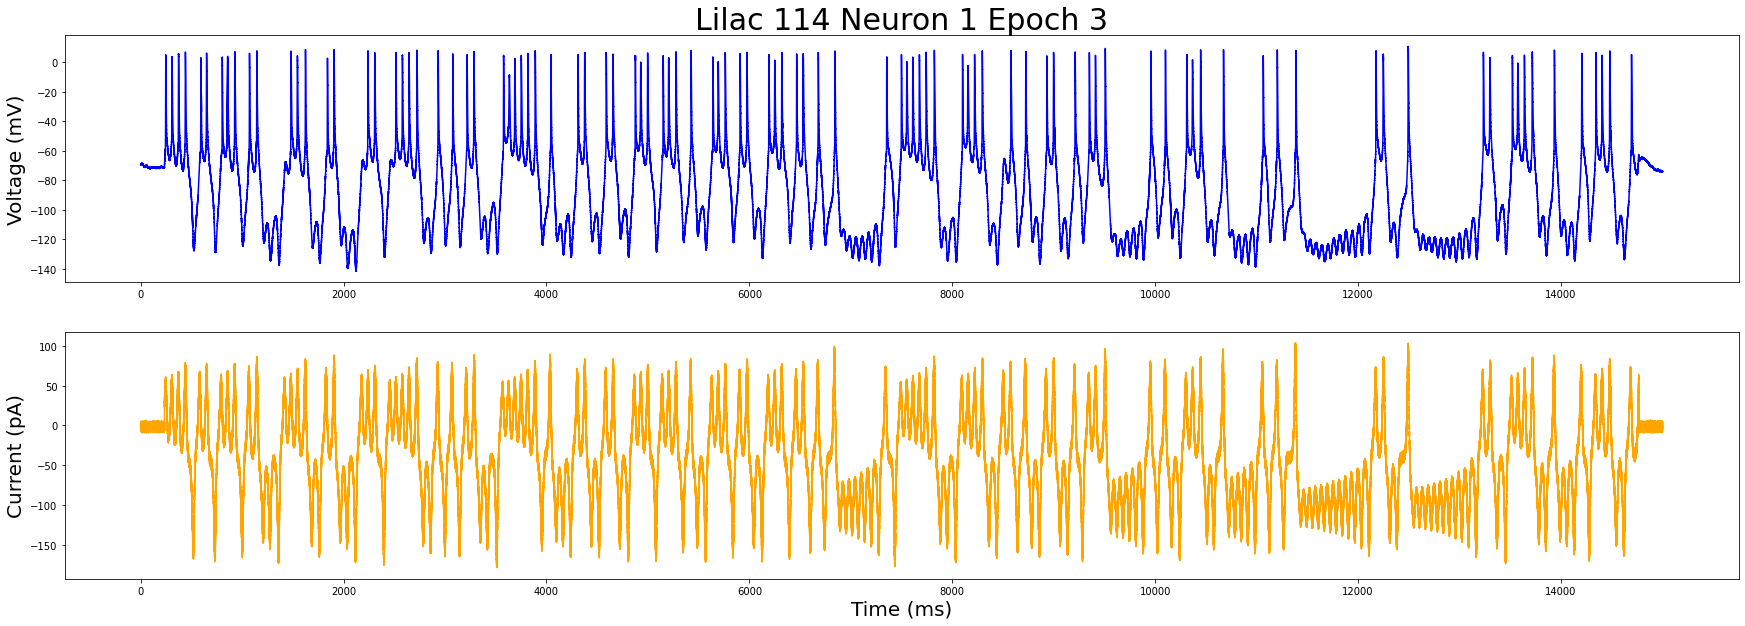

In [53]:
plt.figure(figsize=(30,10))

plt.subplot(2, 1, 1)
plt.plot(loaded_t,loaded_V, color = 'blue')
plt.ylabel('Voltage (mV)',fontsize=20)
plt.title(filename,fontsize=30)

plt.subplot(2, 1, 2)
plt.plot(loaded_t,loaded_I, color = 'orange')
plt.ylabel('Current (pA)',fontsize=20)
plt.xlabel('Time (ms)',fontsize=20)

plt.savefig(dire+filename)

In [54]:
Xdata = Voltage_train
NoCenters_no_thresh = 200
# NoCenters_above_thresh = 50
DDF = Gauss()
# Combine centers above threshold with centers determined by kmeans
Center = DDF.KmeanCenter(Xdata,NoCenters_no_thresh,D,length,tau)

Current_train = loaded_I[:train_timestep_end]
stim_train = Current_train

F = DDF.FuncApproxF(Xdata,length,Center,beta,R,D,stim_train,tau)
Pdata = Voltage_test
Current_test = loaded_I[train_timestep_end:total_num_timesteps_in_data]
PredValidation = DDF.PredictIntoTheFuture(F,PreLength,Current_test[bias-1:],Pdata[bias-1-(D-1)*tau:])

Length+1: 499001
Shape of Xdata: (500000,)
Shape of XTau: (15, 499001)
Sample Xdata over length:(140, 499141)


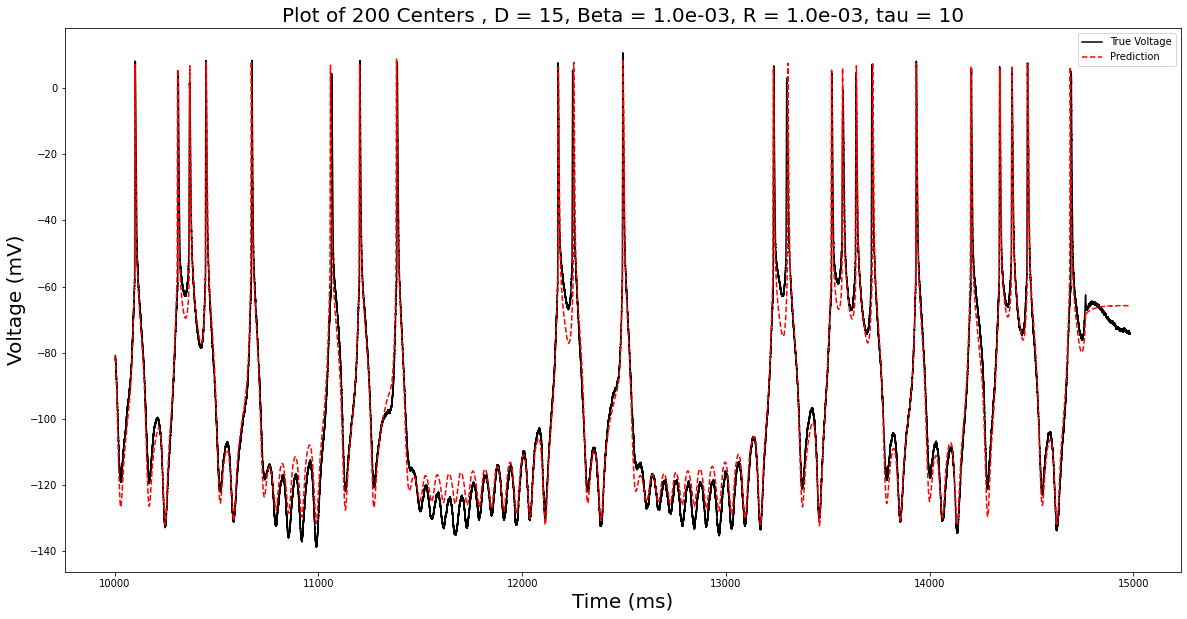

In [55]:
plt.figure(figsize=(20,10))
plt.plot(X,Pdata[bias:bias + PreLength],label = 'True Voltage', color = 'black')
plt.plot(X,PredValidation[tau*(D-1)+1:tau*(D-1)+PreLength+1],'r--',label = 'Prediction')
plt.xlabel('Time ('+str(Time_units)+')',fontsize=20)
plt.ylabel('Voltage ('+str(Voltage_units)+')',fontsize=20)
plt.legend()
plt.title('Plot of 200 Centers '+title_here,fontsize=20)
plt.savefig(dire+'200 Centers '+title_here+'.png')

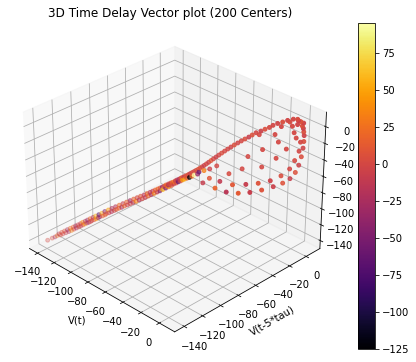

In [56]:
fig=plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
weights = DDF.W[:-1]
p=ax.scatter3D(Center[:, 0], Center[:, 4], Center[:, 9], c=weights, cmap=plt.cm.inferno, s=15)
plt.title("3D Time Delay Vector plot (200 Centers)")
ax.set_xlabel("V(t)", fontsize=10)
ax.set_ylabel("V(t-5*tau)", fontsize=10)
ax.set_zlabel("V(t-10*tau)", fontsize=10)
ax.view_init(30,-45)
fig.colorbar(p, ax=ax)
plt.savefig(dire+'Weight plot of 200 Centers '+title_here+'.png')

In [57]:
def SelectRange(low, high, Xdata):
    fish = []
    for x in Voltage_train:
        if x<high and x>low:
            fish.append(x)
    return np.array(fish)


In [58]:
Xdata2 = SelectRange(-75,-40,Xdata)
NoCenters_no_thresh2 = 100
Center2 = DDF.KmeanCenter(Xdata2,NoCenters_no_thresh2,D,len(Xdata2)-1000,tau)

Centers2 = np.concatenate([Center,Center2])
F2 = DDF.FuncApproxF(Xdata,length,Centers2,beta,R,D,stim_train,tau)
PredValidation2 = DDF.PredictIntoTheFuture(F2,PreLength,Current_test[bias-1:],Pdata[bias-1-(D-1)*tau:])


Length+1: 499001
Shape of Xdata: (500000,)
Shape of XTau: (15, 499001)
Sample Xdata over length:(140, 499141)


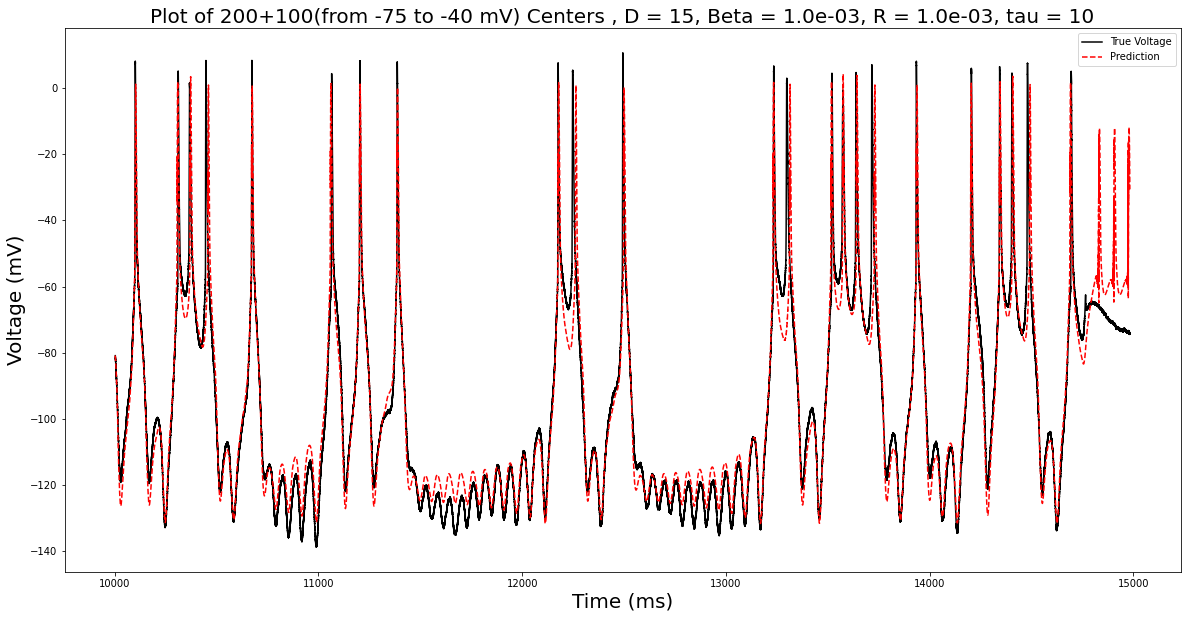

In [59]:
plt.figure(figsize=(20,10))
plt.plot(X,Pdata[bias:bias + PreLength],label = 'True Voltage', color = 'black')
plt.plot(X,PredValidation2[tau*(D-1)+1:tau*(D-1)+PreLength+1],'r--',label = 'Prediction')
plt.xlabel('Time ('+str(Time_units)+')',fontsize=20)
plt.ylabel('Voltage ('+str(Voltage_units)+')',fontsize=20)
plt.legend()
plt.title('Plot of 200+100(from -75 to -40 mV) Centers '+title_here,fontsize=20)
plt.savefig(dire+'200+100 Centers '+title_here+'.png')

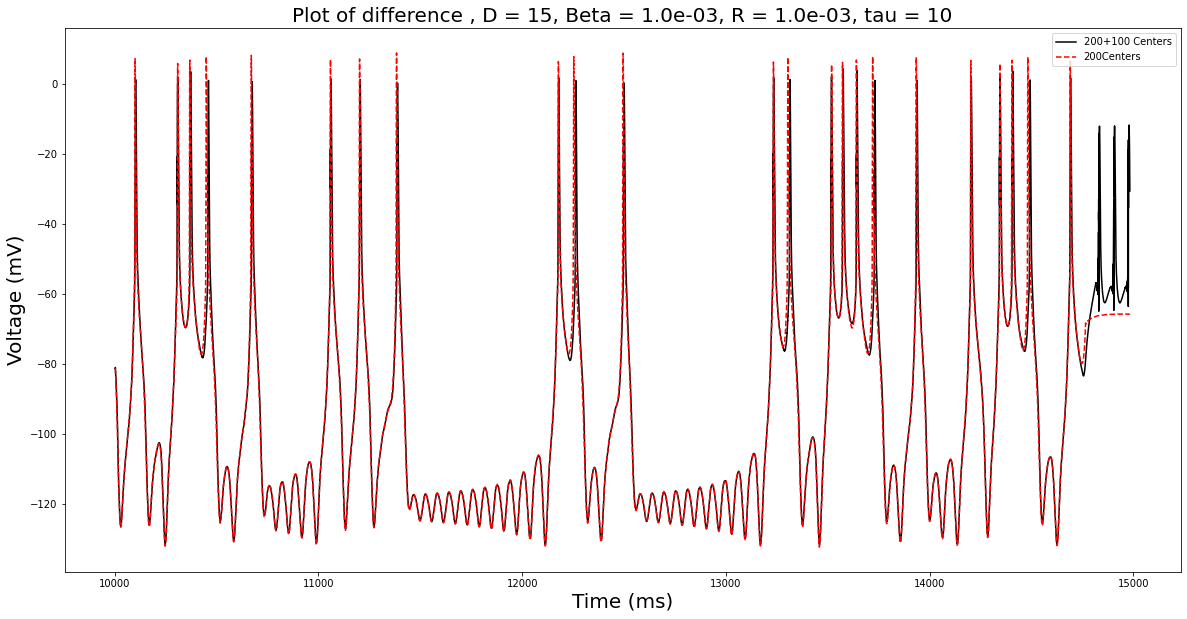

In [62]:
plt.figure(figsize=(20,10))
plt.plot(X,PredValidation2[tau*(D-1)+1:tau*(D-1)+PreLength+1],color = 'black',label = '200+100 Centers')
plt.plot(X,PredValidation[tau*(D-1)+1:tau*(D-1)+PreLength+1],'r--',label = '200Centers')
plt.xlabel('Time ('+str(Time_units)+')',fontsize=20)
plt.ylabel('Voltage ('+str(Voltage_units)+')',fontsize=20)
plt.legend()
plt.title('Plot of difference '+title_here,fontsize=20)
plt.savefig(dire+'Difference '+'title_here'+'.png')

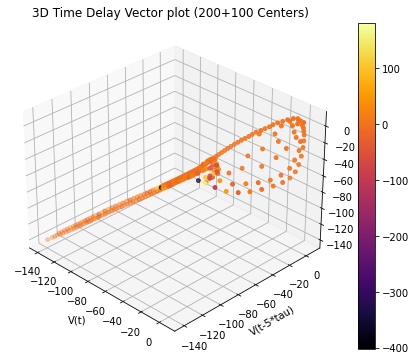

In [61]:
fig=plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
weights = DDF.W[:-1]
p=ax.scatter3D(Centers2[:, 0], Centers2[:, 4], Centers2[:, 9], c=weights, cmap=plt.cm.inferno, s=15)
plt.title("3D Time Delay Vector plot (200+100 Centers)")
ax.set_xlabel("V(t)", fontsize=10)
ax.set_ylabel("V(t-5*tau)", fontsize=10)
ax.set_zlabel("V(t-10*tau)", fontsize=10)
ax.view_init(30,-45)
fig.colorbar(p, ax=ax)
plt.savefig(dire+'Weight plot of 200+100 Centers '+title_here+'.png')